In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import required libraries
%matplotlib inline
from scipy.interpolate import CubicSpline  
import matplotlib.pyplot as plt
import seismic.additional_functions as seis 
import numpy as np
#import segyio
import os

## Practical 2 - CMP gathers, NMO corrections and semblance velocity analysis

In this exercise we will work with a synthetic CMP gather to conduct an NMO correction, without prior knowledge of what the NMO velocities should be (in the NMO exercise in class we knew the correct velocity to use to do the NMO correction- this time we don't!). By working through the exercise you will learn how to conduct semblance analysis to determine the correct velocity profile to use for NMO corrections of a full CMP gather. **As you work on the exercise think about how data science and artificial intelligence may be able to improve on these standard workflows.**

If you have time you can repeat the exercise with a REAL (ie much noiser!) CMP gather in the  [Bonus](./Ex2_Bonus.ipynb)

**Learning Objectives**:
1)	Understand CMP gathers and their physical components
2)	Understand how pre-stack datasets are formatted and how to view them
3)	Understand how and why we need to do NMO corrections


## 2.1 Reading a synthetic CMP gather
In this part of the exercise a synthetic CMP gather will be loaded. 
see [refrences and further reading](#refrences)

CMP gathers display seimic traces for different offsets (the offset is the distance between source and receiver) vs time

**The synthetic CMP gather is already stored in a compressed Numpy format. We will learn more about the SEGY format which is often used for storing seismic data tomorrow in lecture 4.**

In [3]:
data = np.load('data/synthetic_cmp.npz')
list(data.keys())

['dt', 'offsets', 'CMP']

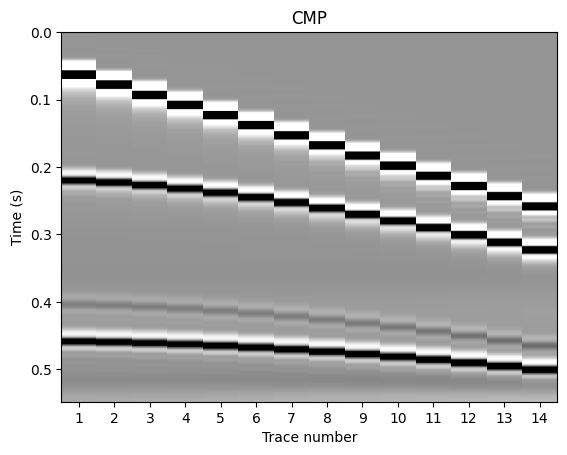

In [4]:
dt = data['dt']
offsets = data['offsets']  
cmp = data['CMP'] 
nsamples = cmp.shape[0] # number of datapoints on each trace
noffsets = cmp.shape[1] # number of traces
times = np.arange(nsamples)*dt # time axis (proportional to depth)
seis.plot(cmp,noffsets, nsamples,dt)

**QUESTION: In lecture 1 we discussed the different ways seismic waves propogate (ie direct arrival, reflection, refraction). These different 'seismic events' will be observed in shot gathers and CMP gathers. What seismic events can you see in this CMP gather? This is worth discussing with your peers.**

<details>
    <summary>💡 Answer</summary>

    There are 4 seismic events observed in this CMP gather
    
from top to bottom:
1) The direct wave (it is linear and the first signal seen which tells us it is the direct arrival)
2) A high amplitude reflection (it is a hyperbola which tells us it is a reflection)
3) A low amplitude reflection
4) A high amplitude reflection


## 2.2. Calculating NMO for our CMP Example

First, we are going to repeat what we did during the lecture and conduct an NMO correction using known velocities. This is to remind you how the NMO correction is done, and also this example is slightly more complicated as we have 3 reflections now not one. Once we have done that we will then move on to trying to determine the NMO velocities for yourselves!

In [5]:
# known velocities, see later how these are obtained in reality
v1, t1 = 3800, 0.22
v2, t2 = 4800, 0.46

# create velocity profile for section. This will be used for the correction, different layers require different velocities to be corrected well
v_nmo = v1 + ((v2 - v1)/(t2 - t1))*(times - t1)  # equation for a straight line between two points. It is linear

In [6]:
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo)

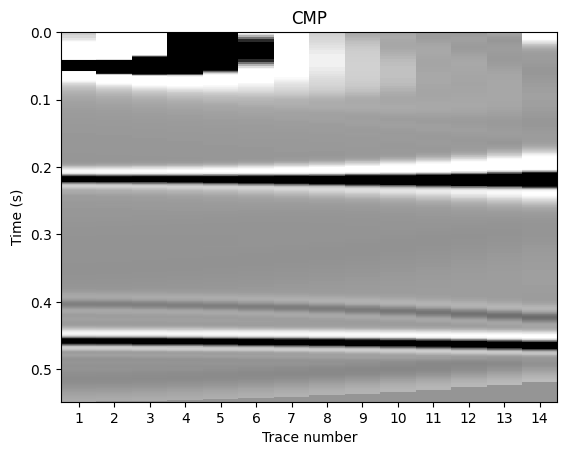

In [7]:
seis.plot(nmo, noffsets, nsamples,dt)

As we saw in class, the NMO correction results in a stretch at large offsets (large trace numbers). This effect is more signifiant for shallower reflections with a short travel time. The direct arrival (the first seismic signal here) is not a reflection so it makes no sense to NMO correct it - that is why it looks so odd. When we process seismic data we apply a process called 'muting' which removes direct arrivals (it basically cuts them out of the data- we only want the reflections)

## 2.3 Stacking NMO corrected data

Once we have done the NMO correction and the reflections have been corrected to horizontal it is now time to add them together in a process called 'stacking'- see lecture 3. The aim of stacking is to improve the signal to noise ratio. The CMP gather above will collapse to just a single trace where the reflections have a time of to after stacking. 

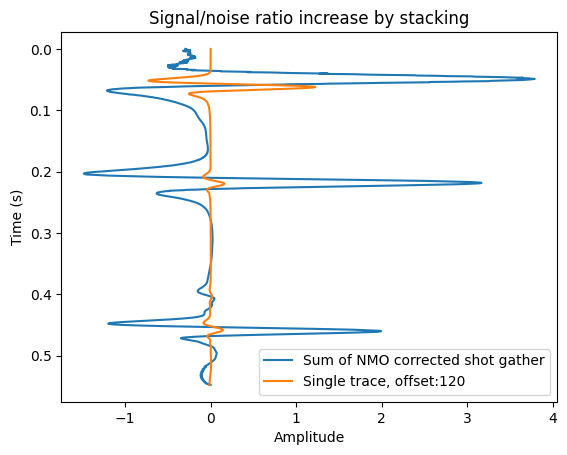

In [8]:
plt.plot(np.sum(nmo, axis = 1), times, label='Sum of NMO corrected shot gather')
plt.plot(cmp[:,0], times, label='Single trace, offset:' + str(offsets [0]))
plt.title("Signal/noise ratio increase by stacking")
plt.ylabel('Time (s)')
plt.xlabel('Amplitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In this example we used a synthetic CMP without noise. CMP stacking can, however, help you remove noise from noisy data. Since noise is partially random it will not sum up nicely like the NMO corrected reflections, so its amplitude in the stacked data will be low compared to the reflections. Have a go at the bonus exercise to try working with real CMP data.

##  2.2. Conducting a semblance analysis to determine NMO velocities

In reality, in order to find the correct NMO velocities for a full seismic trace we would need to do something called 'semblance analysis'- see lecture 3. This involves computing and applying NMO corrections for a wide range of velocities from lower than expected for the study area to higher. A calculation is done to assess the success of the NMO correction. In our simple example we are going to stack the NMO corrected gathers and calculate the maximum amplitude. When we have computed the NMO velocities correctly for a particular reflector we will get the highest stacked amplitudes. Doing this for all reflections within the seismic trace produces a semblance plot from which a seismic data processor can, in most cases manually, select the correct velocities to use.

In [9]:
num = 10 # number of velocities to be tested (semblance plot resolution)
v_test = np.linspace(1000, 7000, num) # V testing range: [minimum velocity, maximum velocity, number of intervals/steps]

amp_store = seis.semblance(v_test, cmp, dt, offsets, times, verbose = True)

progress =  10.0 %
progress =  20.0 %
progress =  30.0 %
progress =  40.0 %
progress =  50.0 %
progress =  60.0 %
progress =  70.0 %
progress =  80.0 %
progress =  90.0 %
progress =  100.0 %


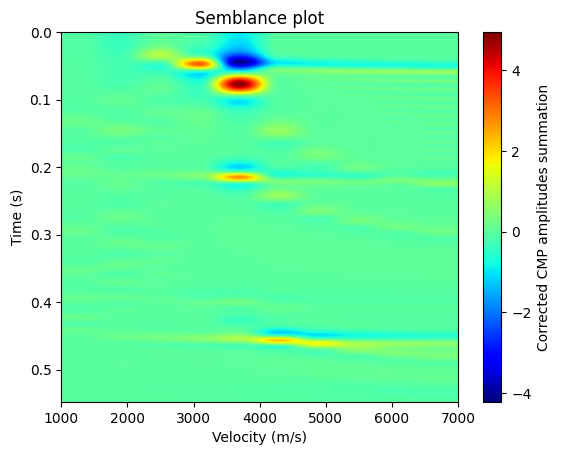

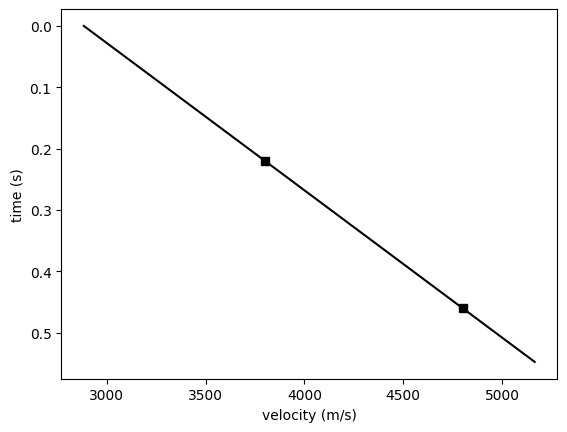

In [10]:
plt.imshow(np.swapaxes(amp_store,0,1), extent=[np.min(v_test), np.max(v_test),
                                            np.max(times), 0], aspect="auto",cmap='jet')
plt.title ('Semblance plot')
plt.colorbar(label = 'Corrected CMP amplitudes summation')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time (s)')
plt.show()
plt.plot(v_nmo, np.arange(nsamples)*dt, '-k')
plt.plot([v1, v2], [t1, t2], 'sk')
plt.xlabel('velocity (m/s)')
plt.ylabel('time (s)')
plt.gca().invert_yaxis()


Because we only have 4 seismic events in our synthetic CMP gather we don't have that many 'bulls eyes' in our semblance diagram. The direct arrival is not a reflection, so there the semblance plot at the depth of the direct arrival (<0.1 s) is nonsense and we can ignore it. We only care about finding the velocity for the three reflections. The reflection with a to of around 0.2 clearly shows up in the semblace plot with a velocity around 3600 m/s. The low amplitude reflection with a to around 0.4 doesn't really show up at all (maybe the amplitude was too low) so we can't determine a velocity for it. The reflection with a to around 0.46 s gives a very wide bulls eye and it is difficult to pick the correct velocity precisely - this is a real feature of semblance analysis. It is difficult to get precise estimates of velocity at depth. In practice, you would select the velocities for the reflections you are confident in and then apply a (linear) interpolation between them. This will be the velocity profile you use to NMO correct your CMP gather for all travel times. 

## 2.3 Picking the correct NMO velocities
**NOTE: you can ignore this excercise if you have problem with opencv**

In this section we have developed a tool to allow you to manually pick the correct velocities for NMO analysis and apply them. If you are feeling adventurous feel free to write your own functions to carry out this process once you are done with the practical.
The observed velocity profile is just a simple piecewise linear function example, we could use more complex functions to fit between velocities. Feel free to implement an alternative fitting function if you have extra time! For some ideas see: https://reproducibility.org/RSF/book/jsg/avo/paper_html/node7.html

In [11]:
NMO_val = seis.click(amp_store, v_test, times) # right click to obtain data, escape to close window
#v_nmo = seis.vel_curve (amp_store, NMO_val, times) # create array containing velocity profile
#nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # carry out correction, you can use your own NMO function

QObject::moveToThread: Current thread (0x55f911cd08a0) is not the object's thread (0x55f912973150).
Cannot move to target thread (0x55f911cd08a0)

QObject::moveToThread: Current thread (0x55f911cd08a0) is not the object's thread (0x55f912973150).
Cannot move to target thread (0x55f911cd08a0)

QObject::moveToThread: Current thread (0x55f911cd08a0) is not the object's thread (0x55f912973150).
Cannot move to target thread (0x55f911cd08a0)

QObject::moveToThread: Current thread (0x55f911cd08a0) is not the object's thread (0x55f912973150).
Cannot move to target thread (0x55f911cd08a0)

QObject::moveToThread: Current thread (0x55f911cd08a0) is not the object's thread (0x55f912973150).
Cannot move to target thread (0x55f911cd08a0)

QObject::moveToThread: Current thread (0x55f911cd08a0) is not the object's thread (0x55f912973150).
Cannot move to target thread (0x55f911cd08a0)

QObject::moveToThread: Current thread (0x55f911cd08a0) is not the object's thread (0x55f912973150).
Cannot move to tar

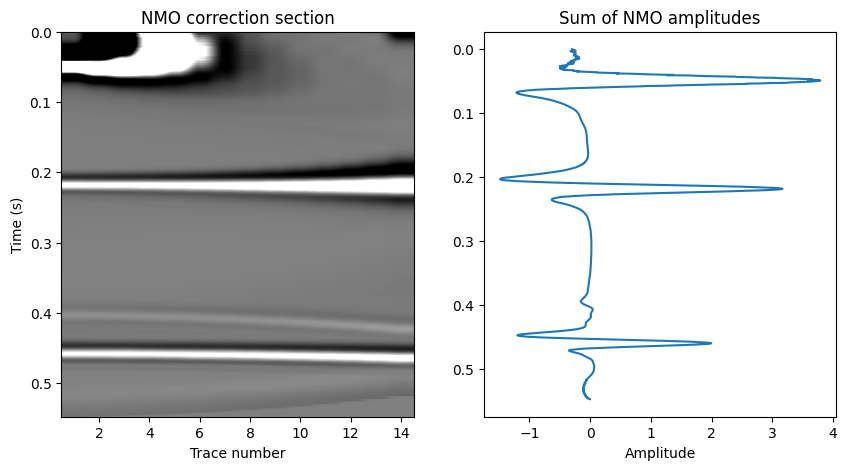

In [12]:
# show results
fig, ax = plt.subplots(1,2, figsize=(10, 5))

# cut-off outliers of data for better visualisation
vm = np.percentile(nmo, 95)
vmin, vmax = -vm, vm

ax[0].imshow(nmo, extent=[0.5, noffsets + 0.5, np.max(times), 0], 
          aspect="auto", cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('NMO correction section')
ax[0].set_xlabel('Trace number')
ax[0].set_ylabel('Time (s)')

ax[1].plot(np.sum(nmo, axis = 1), times)
ax[1].set_title('Sum of NMO amplitudes')
ax[1].set_xlabel('Amplitude')
ax[1].invert_yaxis()

plt.show()

Picking velocities from semblance plots is time consuming and subjective. Surely machine learning methods can help us here? Take a look at this paper which uses ML methods to automatically select the correct velocites for NMO correction from semblance plots- https://arxiv.org/pdf/2205.03645.pdf 

Bonus- Conducting NMO corrections with a real CMP gather

In [Bonus](./Ex2_Bonus.ipynb) you will load a segy file of a real CMP gather and conduct your own NMO correction, courtesy of Rob allen from the VoilA project (now a professional seismic processor at CGG). You will quickly see that the reality of the situation is more complex then our examples above and there is a need to develop better methods to cope with real seismic data. 


# Refrences and Further Reading: 
<a id='refrences'></a>

- https://wiki.seg.org/wiki/Geophysical_tutorials.
- https://github.com/pinga-lab/nmo-tutorial/blob/master/step-by-step-nmo.ipynb
- https://arxiv.org/pdf/2205.03645.pdf